In [1]:
import pandas as pd

In [2]:
pd.set_option('display.max_columns', None)

# COVID-19

In [3]:
data = pd.read_csv('latest_raw.csv', encoding='latin-1')

In [4]:
data.ENTIDAD.unique()

array(['Sinaloa', 'Jalisco', 'Chihuahua', 'Ciudad de Mexico',
       'Nuevo Leon', 'Morelos', 'Tabasco', 'Mexico', 'Coahuila', 'Sonora',
       'San Luis Potosi', 'Tamaulipas', 'Guanajuato', 'Quintana Roo',
       'Yucatan', 'Baja California', 'Puebla', 'Zacatecas', 'Hidalgo',
       'Baja California Sur', 'Michoacan', 'Veracruz', 'Aguascalientes',
       'Durango', 'Guerrero', 'Oaxaca', 'Tlaxcala', 'Nayarit', 'Chiapas',
       'Queretaro', 'Colima', 'Campeche'], dtype=object)

In [5]:
#data.isnull().head(), data.isnull().tail()

In [6]:
data.isnull().values.any()

True

In [7]:
data.isnull().values.sum()

8

In [8]:
# null_data = data[data.isnull().any(axis=1)] # missing city of residente

In [9]:
# Totals and delta

In [55]:
df = data[~data.isnull().any(axis=1)]

In [56]:
df = df[df['RESULTADO']==1]

In [57]:
df = df[~df.FECHA_DEF.str.startswith(('9999'))]

In [58]:
df = data[['FECHA_ARCHIVO', 'FECHA_SINTOMAS', 'DELAY', 'ENTIDAD']]

In [59]:
df = df.rename(
    columns = {
        'FECHA_ARCHIVO':'Date_Confirmed',
        'FECHA_SINTOMAS':'Date_Symptoms',
        'FECHA_DEF':'Date_Death',
        'RESULTADO':'Status',
        'ENTIDAD':'Region',
        'DELAY':'Delay'
    })

In [60]:
df['Date_Confirmed'] = pd.to_datetime(df.Date_Confirmed, format='%Y-%m-%d', errors='coerce')
df['Date_Confirmed'] = df['Date_Confirmed'].dt.strftime('%Y-%m-%d')

In [61]:
    # Region delta (ie, new cases)
cum_df = (df.groupby(['Region','Date_Confirmed'])['Date_Confirmed'].count()).to_frame()

In [62]:
    # Rename because duplicate index
cum_df['Region_Delta'] = cum_df['Date_Confirmed']

In [63]:
    # Region cumulative by date
cum_df['Region_Cumulative'] = cum_df.groupby(['Region'])['Region_Delta'].cumsum()

In [64]:
    # Clean up
cum_df = cum_df.drop(['Date_Confirmed'], axis=1)

In [20]:
# To view full table:
# from IPython.core.display import HTML
# display(HTML(cum_df.to_html()))

In [65]:
cum_df

Region_Delta  Region_Cumulative
Region         Date_Confirmed                                 
Aguascalientes 2020-04-12               784                784
               2020-04-13                38                822
               2020-04-14               133                955
               2020-04-15                75               1030
               2020-04-16                72               1102
...                                     ...                ...
Zacatecas      2020-05-08                63               1498
               2020-05-09                49               1547
               2020-05-10                48               1595
               2020-05-11                44               1639
               2020-05-12                85               1724

[992 rows x 2 columns]

# Tables

In [21]:
# Read

In [22]:
pivot_tbl_cum = cum_df.reset_index().pivot('Region','Date_Confirmed','Region_Cumulative').T.reset_index()
pivot_tbl_daily = cum_df.reset_index().pivot('Region','Date_Confirmed','Region_Delta').T.reset_index()

In [23]:
# Save

In [24]:
pivot_tbl_cum.to_csv('output_data/total-mexico-covid19.csv', index=False)
pivot_tbl_daily.fillna(0).to_csv('output_data/daily-mexico-covid19.csv', index=False)

In [25]:
# Set datetime

In [26]:
pivot_tbl_cum['Date_Confirmed'] = pd.to_datetime(pivot_tbl_cum.Date_Confirmed, format='%Y-%m-%d')
pivot_tbl_cum['Date_Confirmed'] = pivot_tbl_cum['Date_Confirmed'].dt.strftime('%Y-%m-%d')

In [27]:
# Set datetime

In [28]:
pivot_tbl_daily['Date_Confirmed'] = pd.to_datetime(pivot_tbl_daily.Date_Confirmed, format='%Y-%m-%d')
pivot_tbl_daily['Date_Confirmed'] = pivot_tbl_daily['Date_Confirmed'].dt.strftime('%Y-%m-%d')

In [29]:
# Set index

In [30]:
pivot_tbl_cum = pivot_tbl_cum.set_index(pd.DatetimeIndex(pivot_tbl_cum['Date_Confirmed']))
pivot_tbl_daily = pivot_tbl_daily.set_index(pd.DatetimeIndex(pivot_tbl_daily['Date_Confirmed']))

# Plots

In [31]:
import janitor

In [32]:
pivot_tbl_cum = pivot_tbl_cum.filter_date('Date_Confirmed','2020-04-13','2020-05-12')
pivot_tbl_daily = pivot_tbl_daily.filter_date('Date_Confirmed','2020-04-13','2020-05-12')

In [33]:
from numpy import *
import math
import matplotlib.pyplot as plt

### Confirmed cases

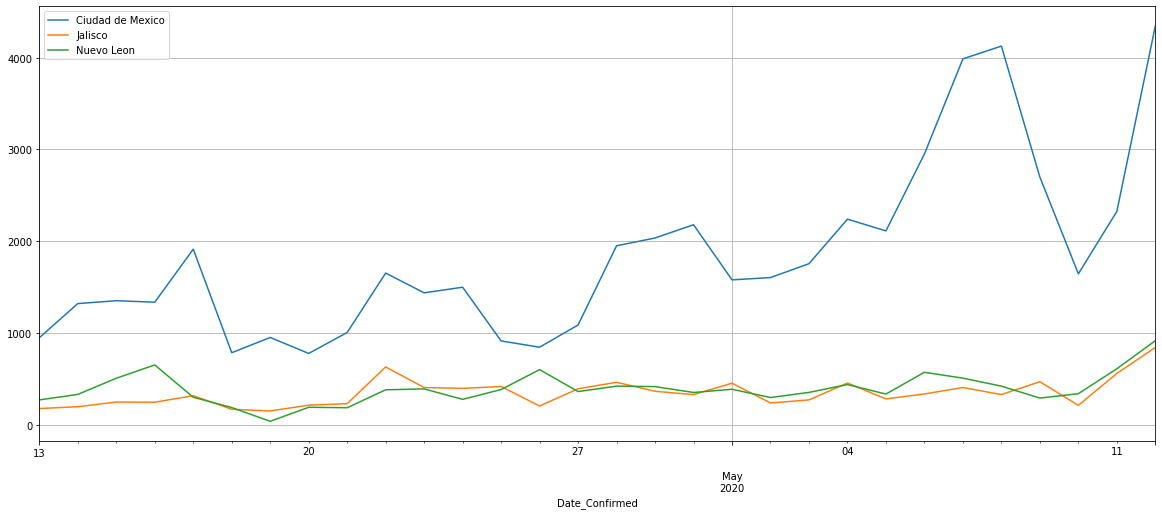

In [34]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon']:
    pivot_tbl_daily[state].fillna(0).plot()

plt.legend()
plt.grid(True)
plt.show()

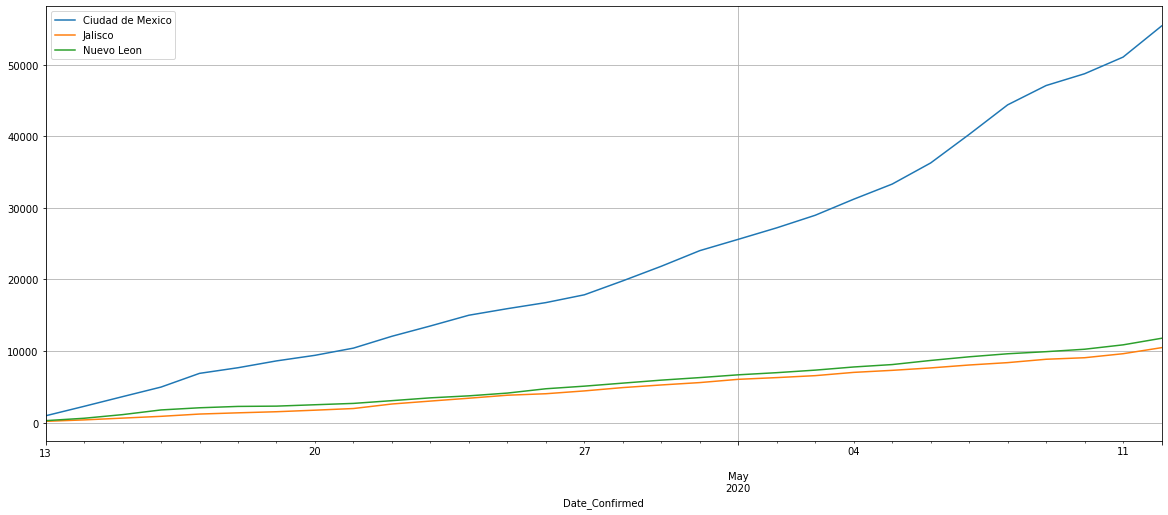

In [35]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon']:
    pivot_tbl_daily[state].fillna(0).cumsum().plot()

plt.legend()
plt.grid(True)
plt.show()

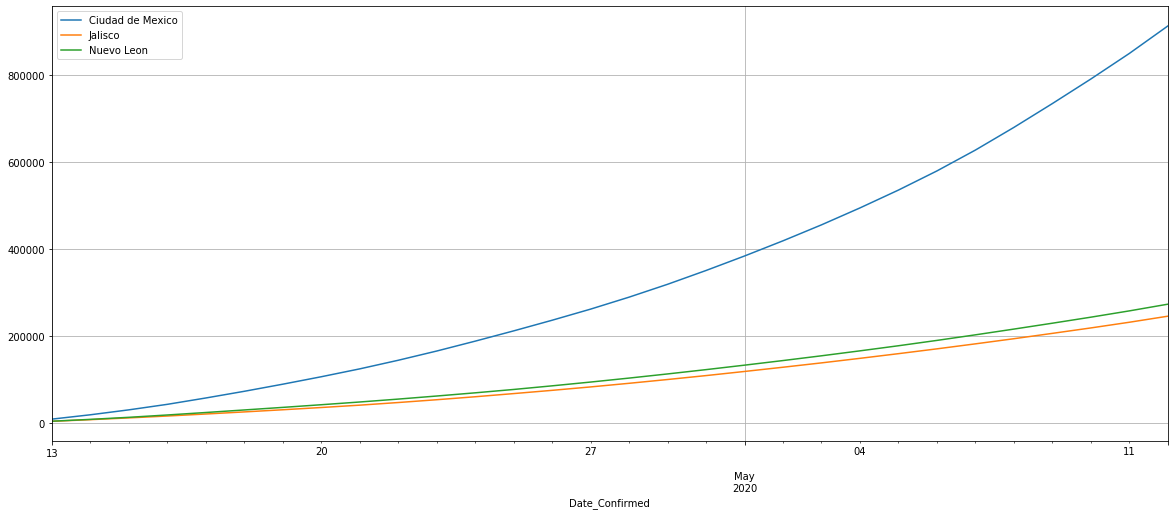

In [36]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon']:
    pivot_tbl_cum[state].fillna(0).cumsum().plot()

plt.legend()
plt.grid(True)
plt.show()

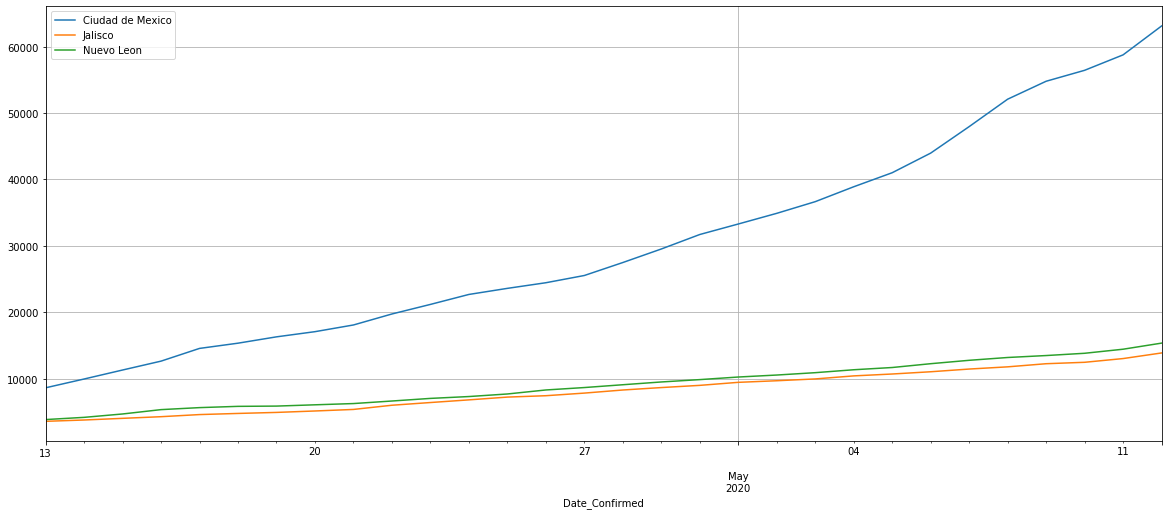

In [37]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon']:
    pivot_tbl_cum[state].fillna(0).plot()

plt.legend()
plt.grid(True)
plt.show()

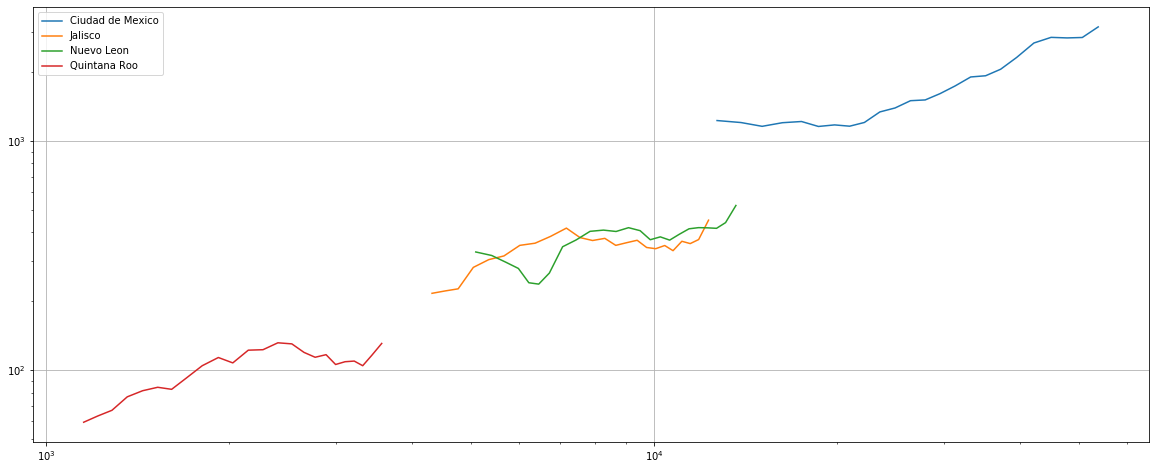

In [38]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon', 'Quintana Roo']:
    plt.plot(list(pivot_tbl_cum[state].dropna().rolling(window=7).mean()), list(pivot_tbl_daily[state].dropna().rolling(window=7).mean()), label=state)

plt.legend()
plt.grid(True)

plt.yscale('log')
plt.xscale('log')

plt.show()

In [73]:
cum_df

Region_Delta  Region_Cumulative
Region         Date_Confirmed                                 
Aguascalientes 2020-04-12               784                784
               2020-04-13                38                822
               2020-04-14               133                955
               2020-04-15                75               1030
               2020-04-16                72               1102
...                                     ...                ...
Zacatecas      2020-05-08                63               1498
               2020-05-09                49               1547
               2020-05-10                48               1595
               2020-05-11                44               1639
               2020-05-12                85               1724

[992 rows x 2 columns]

In [85]:
# Needs fix !!!

# Starting at date w/certain number of cases
def select_min_cases(df, min):
    df2_state = []
    df2_dates = []
    df2_cases = []
    for state in df.columns:
        #print(df.columns)
        for index in range(len(df[state])):
            if df[state][index] > min:
                #print(state)
                #print(df[state].index[index])
                #print((df[state][index]))
                df2_state.append(state)
                df2_dates.append(df[state].index[index])
                df2_cases.append(df[state][index])
            #if df[state][index] < num:
                #print(None)
    #my_df = pd.DataFrame({'Region': pd.Series(df2_state), 'Date_Confirmed': pd.Series(df2_dates), 'Region_Cumulative': pd.Series(df2_cases)})
    #my_df = my_df.set_index(['Region','Date_Confirmed'])
    return df2

min_cases = select_min_cases(cum_df, 15).reset_index()
#min_cases = min_cases.drop(['index'], axis=1).reset_index()
#min_cases = min_cases.reset_index().pivot('Region','Date_Confirmed','Region_Cumulative').T.sort_index()
#min_cases = min_cases.fillna(method='ffill')
#daily_min_cases = min_cases.diff()

#plt.figure(figsize=(20,8))

#for state in ['Jalisco', 'Nuevo Leon']:
#    daily_min_cases[state].fillna(0).rolling(window=7).mean().plot()

#plt.legend()
#plt.grid(True)
#plt.show()

NameError: name 'df2' is not defined

In [84]:
min_cases

,index,Region,Date_Confirmed,Region_Cumulative
0,0,Region_Delta,"(Aguascalientes, 2020-04-12)",784
1,1,Region_Delta,"(Aguascalientes, 2020-04-13)",38
2,2,Region_Delta,"(Aguascalientes, 2020-04-14)",133
3,3,Region_Delta,"(Aguascalientes, 2020-04-15)",75
4,4,Region_Delta,"(Aguascalientes, 2020-04-16)",72
...,...,...,...,...
1942,1942,Region_Cumulative,"(Zacatecas, 2020-05-08)",1498
1943,1943,Region_Cumulative,"(Zacatecas, 2020-05-09)",1547
1944,1944,Region_Cumulative,"(Zacatecas, 2020-05-10)",1595
1945,1945,Region_Cumulative,"(Zacatecas, 2020-05-11)",1639


In [69]:
min_cases = select_min_cases(cum_df, 15)

Index(['Region_Delta', 'Region_Cumulative'], dtype='object')
Index(['Region_Delta', 'Region_Cumulative'], dtype='object')


Index(['Region_Delta', 'Region_Cumulative'], dtype='object')
Index(['Region_Delta', 'Region_Cumulative'], dtype='object')


NameError: name 'daily_min_cases' is not defined

<Figure size 1440x576 with 0 Axes>

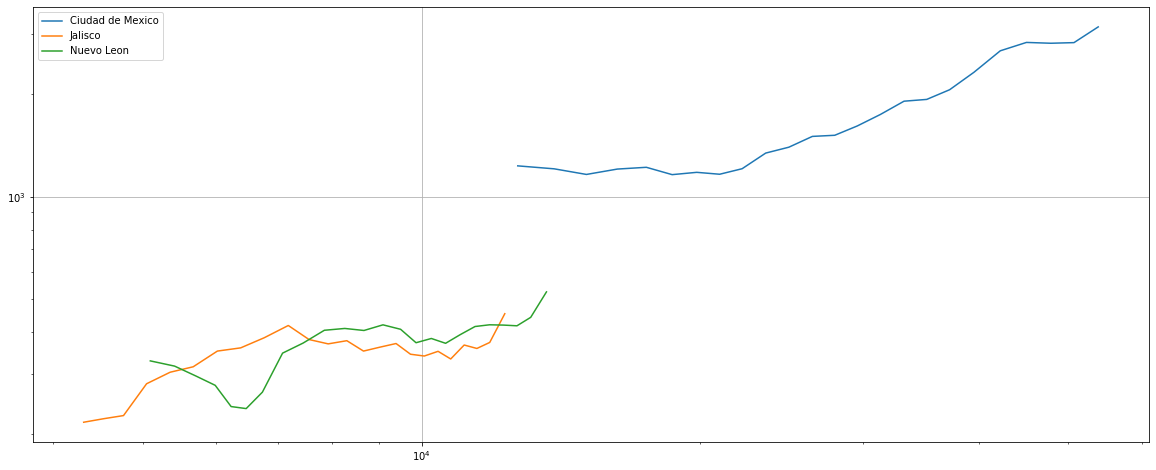

In [39]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon']:
    plt.plot(list(pivot_tbl_cum[state].dropna().rolling(window=7).mean()), list(pivot_tbl_daily[state].dropna().rolling(window=7).mean()), label = state)

plt.legend()
plt.grid(True)

plt.yscale('log')
plt.xscale('log')

plt.show()

### Lag in cases reported

In [40]:
import janitor
test = pivot_tbl_daily
abr_19 = test.filter_date('Date_Confirmed','2020-04-13','2020-05-12')

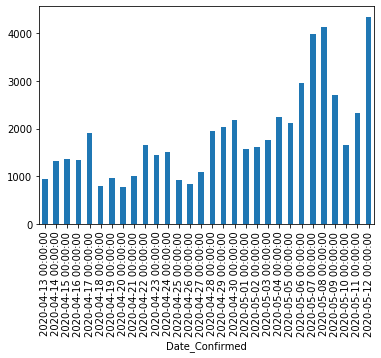

In [188]:
abr_19['Ciudad de Mexico'].plot(kind='bar', title='')